In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os

DATASET_PATH = "/content/drive/MyDrive/project_dataset"
print("Dataset Path:", DATASET_PATH)

Dataset Path: /content/drive/MyDrive/project_dataset


In [3]:
import numpy as np
import cv2

IMG_SIZE = 128

def load_stage1_dataset(dataset_path, limit=None):

    images, masks = [], []

    folders = os.listdir(dataset_path)
    if limit:
        folders = folders[:limit]

    for folder in folders:

        folder_path = os.path.join(dataset_path, folder)

        img_folder = os.path.join(folder_path, "images")
        mask_folder = os.path.join(folder_path, "masks")

        # Load image
        img_file = os.listdir(img_folder)[0]
        img_path = os.path.join(img_folder, img_file)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # Merge masks
        merged_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        for mask_file in os.listdir(mask_folder):
            mask_path = os.path.join(mask_folder, mask_file)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask / 255.0

            merged_mask += mask

        merged_mask = (merged_mask > 0).astype("float32")
        merged_mask = np.expand_dims(merged_mask, axis=-1)

        images.append(img)
        masks.append(merged_mask)

    return np.array(images), np.array(masks)


In [4]:
X = np.load("/content/drive/MyDrive/X.npy")
Y = np.load("/content/drive/MyDrive/Y.npy")

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters):

    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    return x


In [7]:
def UNet(inputs):

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    bn = conv_block(p3, 512)

    # Decoder
    u1 = layers.UpSampling2D()(bn)
    u1 = layers.Concatenate()([u1, c3])
    c4 = conv_block(u1, 256)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = conv_block(u2, 128)

    u3 = layers.UpSampling2D()(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = conv_block(u3, 64)

    return c6


In [8]:
def DoubleUNet(input_shape=(128,128,3)):

    inputs = layers.Input(input_shape)

    # -------- U-Net 1 --------
    unet1_out = UNet(inputs)
    mask1 = layers.Conv2D(1, 1, activation="sigmoid")(unet1_out)

    # Multiply input with mask1
    x = layers.Multiply()([inputs, mask1])

    # -------- U-Net 2 --------
    unet2_out = UNet(x)
    mask2 = layers.Conv2D(1, 1, activation="sigmoid")(unet2_out)

    # Final Output
    outputs = mask2

    return Model(inputs, outputs)


In [9]:
model = DoubleUNet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 15,565,826 (59.38 MB)

 Trainable params: 15,565,826 (59.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [13]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=5,
    batch_size=4
)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 545s 14s/step - accuracy: 0.8343 - loss: 0.5850 - val_accuracy: 0.8229 - val_loss: 0.4944
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 554s 14s/step - accuracy: 0.8723 - loss: 0.3023 - val_accuracy: 0.6317 - val_loss: 0.9637
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 545s 14s/step - accuracy: 0.8646 - loss: 0.2806 - val_accuracy: 0.8872 - val_loss: 0.2420
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 557s 14s/step - accuracy: 0.8972 - loss: 0.2402 - val_accuracy: 0.8826 - val_loss: 0.2488
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 541s 14s/step - accuracy: 0.9028 - loss: 0.2151 - val_accuracy: 0.9169 - val_loss: 0.2001


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


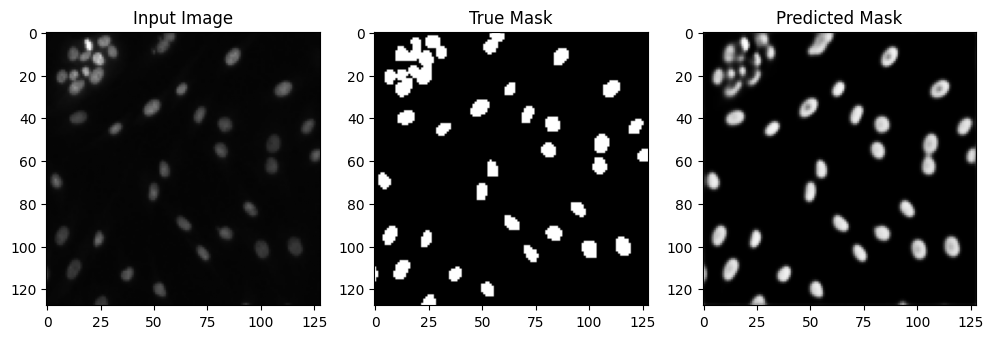

In [14]:
import matplotlib.pyplot as plt

index = 0
pred = model.predict(X_test[index:index+1])[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(X_test[index])

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(Y_test[index].squeeze(), cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred.squeeze(), cmap="gray")

plt.show()


In [15]:
model.save("/content/drive/MyDrive/double_unet_model.h5")
print("Double U-Net Model Saved Successfully!")

Double U-Net Model Saved Successfully!
